# Two Sigma Connect: Rental Listing Inquiries

# 0. Libs

In [74]:
# Import all the tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plots inside the notebook
%matplotlib inline 

# Access to Google Drive

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Preprocessing

* NaN: fillna (pandas), imputer (sklearn), pd.api.types (use filna, loop) if large dataset
* Removing unnecessary columns (like id)
* Objects -> int columns: OneHotEncoder() (sklearn), pd.get_dummies (pandas, define all columns, clever lib)
* Check and remove outliers if needed
* Convert datetime with new int columns

# 1.1. Loading data

## File train.json, which contains data related to the apartments
* Predict `interest_level` is defined by the number of inquiries a listing

In [76]:
df = pd.read_json("/content/drive/MyDrive/Colab_Notebooks/CFT_work/train.json")

In [77]:
df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low


In [78]:
df.shape, df.dtypes

((49352, 15), bathrooms          float64
 bedrooms             int64
 building_id         object
 created             object
 description         object
 display_address     object
 features            object
 latitude           float64
 listing_id           int64
 longitude          float64
 manager_id          object
 photos              object
 price                int64
 street_address      object
 interest_level      object
 dtype: object)

In [79]:
df.isna().sum() # there is no NaN

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
interest_level     0
dtype: int64

In [80]:
# Check for numeric.d
for labels, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        print(labels)

bathrooms
bedrooms
latitude
listing_id
longitude
price


In [81]:
df.drop('photos', axis = 1, inplace=True)

## Result in section

* There is no NaN

# 1.2. Columns processing

## price

In [82]:
df['price'].head(20)

4     2400
6     3800
9     3495
10    3000
15    2795
16    7200
18    6000
19    1945
23    2435
32    6850
33    2785
36    3100
38    2400
39    2750
42    5465
43    3150
44    3750
46    4450
49    3200
61    2495
Name: price, dtype: int64

In [83]:
df['price'].describe()

count    4.935200e+04
mean     3.830174e+03
std      2.206687e+04
min      4.300000e+01
25%      2.500000e+03
50%      3.150000e+03
75%      4.100000e+03
max      4.490000e+06
Name: price, dtype: float64

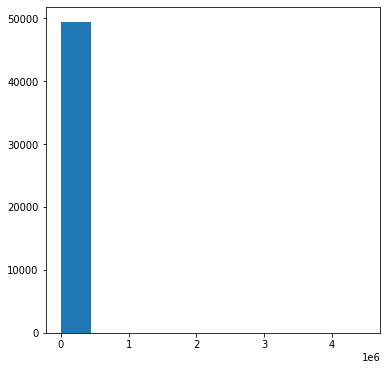

In [84]:
# see the 'price' distribution

fig, ax = plt.subplots(figsize=(6,6))
ax.hist(df['price'], bins=10);

In [85]:
max(df['price'])

4490000

In [86]:
min(df['price'])

43

In [87]:
# change column 'price'
# df_price = df.copy()

# def price(x):
#   if x < 1000:
#     return x * 1000
#   elif x > 50000:
#     return x/10
#   else: 
#     return x

# df_price['price'] = df_price.apply(lambda x: price(x['price']), axis=1)

In [88]:
df_price = df.copy()
# log price
df_price['log_price'] = np.log2(df_price['price'])
df_price.drop('price',axis=1, inplace=True)
df_price.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,street_address,interest_level,log_price
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,145 Borinquen Place,medium,11.228819


In [89]:
df_price['log_price'].describe()

count    49352.000000
mean        11.684434
std          0.624453
min          5.426265
25%         11.287712
50%         11.621136
75%         12.001408
max         22.098284
Name: log_price, dtype: float64

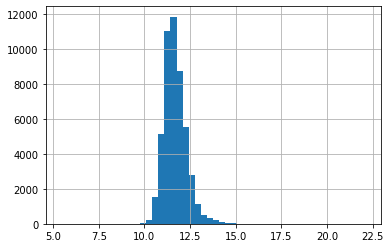

In [90]:
df_price['log_price'].hist(bins=50)

## bathrooms

* can not be 0, 0 -> 1
* make a new feature 
* can not be 10 (see distribution)

In [91]:
df_price['bathrooms'].head(10)

4     1.0
6     1.0
9     1.0
10    1.5
15    1.0
16    1.0
18    2.0
19    1.0
23    0.0
32    3.0
Name: bathrooms, dtype: float64

In [92]:
df_price['bathrooms'].describe()

count    49352.00000
mean         1.21218
std          0.50142
min          0.00000
25%          1.00000
50%          1.00000
75%          1.00000
max         10.00000
Name: bathrooms, dtype: float64

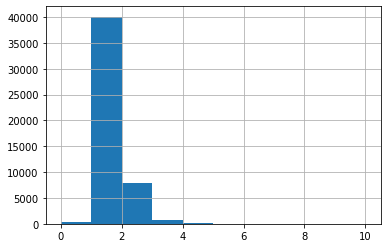

In [93]:
df_price['bathrooms'].hist(bins=10);

### 0 -> 1

In [94]:
# change '0' to '1'
df_baths = df_price.copy()

def bath(x):
  if x == 0:
    return 1
  else:
    return x

df_baths['bathrooms'] = df_price.apply(lambda x: bath(x['bathrooms']), axis=1)

In [95]:
df_baths['bathrooms'].describe()

count    49352.000000
mean         1.218522
std          0.492288
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         10.000000
Name: bathrooms, dtype: float64

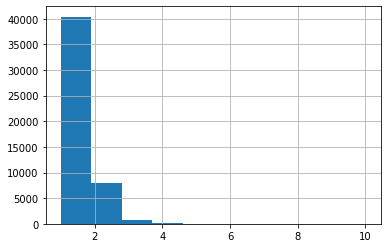

In [96]:
df_baths['bathrooms'].hist(bins=10);

In [97]:
df_price['bathrooms'].head(10)

4     1.0
6     1.0
9     1.0
10    1.5
15    1.0
16    1.0
18    2.0
19    1.0
23    0.0
32    3.0
Name: bathrooms, dtype: float64

In [98]:
df_baths['bathrooms'].head(10)

4     1.0
6     1.0
9     1.0
10    1.5
15    1.0
16    1.0
18    2.0
19    1.0
23    1.0
32    3.0
Name: bathrooms, dtype: float64

### Remove max. Adjust distribution


In [99]:
# remove max 10. See distribution why
def bath_max(x):
  if x > 5:
    return df_baths['bathrooms'].mean()
  else:
    return x

df_baths['bathrooms'] = df_baths.apply(lambda x: bath_max(x['bathrooms']), axis=1)

In [100]:
df_baths['bathrooms'].describe()

count    49352.000000
mean         1.217299
std          0.485624
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: bathrooms, dtype: float64

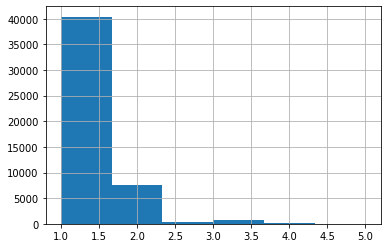

In [101]:
df_baths['bathrooms'].hist(bins=6);

### New feature (if bath not a whole number)

In [102]:
# make a new feature

def add_tiol(x):
  if (x).is_integer() == True:
    return 0
  else:
    # if not a whole (plus toilet for example)
    return 1

df_baths['addition_bath'] = df_baths.apply(lambda x: add_tiol(x['bathrooms']), axis=1)

In [103]:
df_baths.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,street_address,interest_level,log_price,addition_bath
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,145 Borinquen Place,medium,11.228819,0
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,230 East 44th,low,11.891784,0
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,405 East 56th Street,medium,11.771077,0
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,792 Metropolitan Avenue,medium,11.550747,1
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,340 East 34th Street,low,11.448633,0


## bedrooms
* 0 -> 1

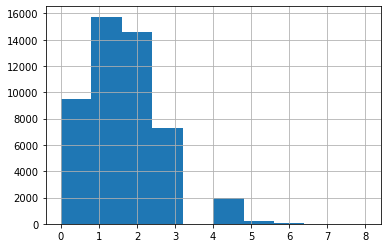

In [104]:
df_baths['bedrooms'].hist(bins=10);

In [105]:
df_baths['bedrooms'].describe()

count    49352.000000
mean         1.541640
std          1.115018
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: bedrooms, dtype: float64

### 0 -> 1

In [106]:
df_beds = df_baths.copy()

def bedroom(x):
  if x == 0:
    return 1
  else:
    return x

df_beds['bedrooms'] = df_beds.apply(lambda x: bedroom(x['bedrooms']), axis=1)

In [107]:
df_beds['bedrooms'].describe()

count    49352.000000
mean         1.733628
std          0.898016
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: bedrooms, dtype: float64

## new feature based on geo and price
* create new feature based on latitude/longitude


In [108]:
# Check for numeric. Now we only should adjust: latitude, longitude, listing_id
for labels, content in df_beds.items():
    if pd.api.types.is_numeric_dtype(content):
        print(labels)

bathrooms
bedrooms
latitude
listing_id
longitude
log_price
addition_bath


In [109]:
df_beds.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,street_address,interest_level,log_price,addition_bath
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,145 Borinquen Place,medium,11.228819,0


In [110]:
x = df_beds.copy()
x = x.drop('bathrooms', axis=1)
x = x.drop('bedrooms', axis=1)
x = x.drop('building_id', axis=1)
x = x.drop('created', axis=1)
x = x.drop('description', axis=1)
x = x.drop('display_address', axis=1)
x = x.drop('features', axis=1)
x = x.drop('listing_id', axis=1)
x = x.drop('manager_id', axis=1)
x = x.drop('street_address', axis=1)
x = x.drop('interest_level', axis=1)
x = x.drop('addition_bath', axis=1)
y = x['log_price']
x = x.drop('log_price', axis=1)

# x['longitude'] = x['longitude'].abs()

x.head(2)

,latitude,longitude
4,40.7108,-73.9539
6,40.7513,-73.9722


In [111]:
y.head()

4     11.228819
6     11.891784
9     11.771077
10    11.550747
15    11.448633
Name: log_price, dtype: float64

### Predict price

In [112]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor()
clf = clf.fit(x, y)

In [113]:
clf.score(x,y)

0.7571793300719405

### Compare models

In [114]:
# !pip install catboost

In [115]:
# # Put model in a dictionary
# from catboost import CatBoostRegressor
# from sklearn.linear_model import Lasso, Ridge
!pip install catboost
# models = {"CatBoost": CatBoostRegressor(verbose=False),
#          "Random Forest": RandomForestRegressor(),
#           "Lasso": Lasso(),
#           "Ridge": Ridge(),}

# # Create the function to fit and score models
# def fit_and_score(models, x, y):
#     """
#     Fits and evaluates given ml models
#     """
    
#     # Set random seed
#     np.random.seed(42)
#     # Make a dictionary to keep scores
#     model_scores = {}
#     #Loop through model
#     for name, model in models.items():
#         # Fit the model to the data
#         model.fit(x, y)
#         model_scores[name] = model.score(x, y)
#     return model_scores

In [116]:
# model_scores = fit_and_score(models=models, x = x, y = y)
# model_scores

### New feature

In [117]:
y_preds = clf.predict(x)

In [118]:
df_discrict_price = df_beds.copy()
df_discrict_price['distr_eff'] = y_preds
df_discrict_price.head(1)


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,street_address,interest_level,log_price,addition_bath,distr_eff
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,145 Borinquen Place,medium,11.228819,0,11.270777


In [119]:
# price dependence on geography
def geo_price(x, y):
  return x/y

df_discrict_price['geo_effect'] = df_discrict_price.apply(lambda x: geo_price(x['log_price'], x['distr_eff']), axis=1)
df_discrict_price.drop('distr_eff', axis=1, inplace=True)
df_discrict_price.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,street_address,interest_level,log_price,addition_bath,geo_effect
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,145 Borinquen Place,medium,11.228819,0,0.996277


## Geo data
* Same for train and test. Decided to keep it comment

In [120]:
# df_discrict_price.shape

### latitude

In [121]:
# df_discrict_price['latitude'].describe()

In [122]:
# from numpy.core.numeric import NaN
# # price dependence on geography
# df_city = df_discrict_price.copy()
# new_york_latitude = 40.73 
# def check_latitude(x):
#   if x < 40.2:
#     return 0
#   elif x > 42:
#     return 0
#   else: return x

# df_city['latitude'] = df_city.apply(lambda x: check_latitude(x['latitude']), axis=1)

# df_city.head(1)

In [123]:
# df_city['latitude'].isna().sum()

In [124]:
# df_city['latitude'].describe()

### address

In [125]:
df_discrict_price.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,street_address,interest_level,log_price,addition_bath,geo_effect
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,145 Borinquen Place,medium,11.228819,0,0.996277
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,230 East 44th,low,11.891784,0,0.987594
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,405 East 56th Street,medium,11.771077,0,1.007684
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,792 Metropolitan Avenue,medium,11.550747,1,1.015401
15,1.0,1,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,340 East 34th Street,low,11.448633,0,0.983101


## date
* adjust created

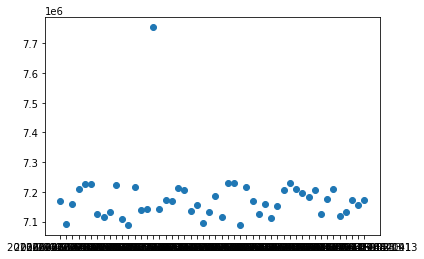

In [126]:
# the is dependence
fig, ax =  plt.subplots()
ax.scatter(df_discrict_price["created"][:50], df_discrict_price["listing_id"][:50])

In [127]:
df_discrict_price.dtypes

bathrooms          float64
bedrooms             int64
building_id         object
created             object
description         object
display_address     object
features            object
latitude           float64
listing_id           int64
longitude          float64
manager_id          object
street_address      object
interest_level      object
log_price          float64
addition_bath        int64
geo_effect         float64
dtype: object

In [128]:
df_discrict_price['created'] = pd.to_datetime(df_discrict_price['created'], format='%Y-%m-%d %H:%M:%S')

In [129]:
df_discrict_price.dtypes

bathrooms                 float64
bedrooms                    int64
building_id                object
created            datetime64[ns]
description                object
display_address            object
features                   object
latitude                  float64
listing_id                  int64
longitude                 float64
manager_id                 object
street_address             object
interest_level             object
log_price                 float64
addition_bath               int64
geo_effect                float64
dtype: object

In [130]:
# Add datetime parameter
df_date = df_discrict_price.copy()
df_date["Year"] = df_date.created.dt.year
df_date["Month"] = df_date.created.dt.month
df_date["Day"] = df_date.created.dt.day

df_date["Hour"] = df_date.created.dt.hour
df_date["Min"] = df_date.created.dt.minute
df_date["Sec"] = df_date.created.dt.second


# # Now we can remove date column
df_date.drop("created", axis =1, inplace=True)

df_date.head(2)

,bathrooms,bedrooms,building_id,description,display_address,features,latitude,listing_id,longitude,manager_id,street_address,interest_level,log_price,addition_bath,geo_effect,Year,Month,Day,Hour,Min,Sec
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,145 Borinquen Place,medium,11.228819,0,0.996277,2016,6,16,5,55,27
6,1.0,2,b8e75fc949a6cd8225b455648a951712,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,230 East 44th,low,11.891784,0,0.987594,2016,6,1,5,44,33


In [131]:
df_discrict_price.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,street_address,interest_level,log_price,addition_bath,geo_effect
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,145 Borinquen Place,medium,11.228819,0,0.996277
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,230 East 44th,low,11.891784,0,0.987594


## id's
* no dependence, let's remove

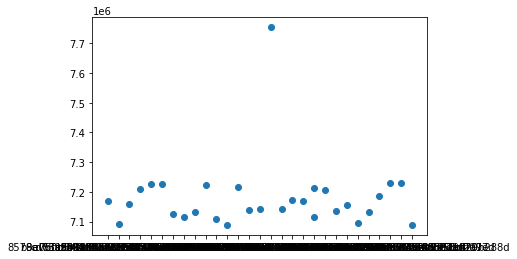

In [132]:
# building_id
fig, ax =  plt.subplots()
ax.scatter(df_date["building_id"][:30], df_date["listing_id"][:30])

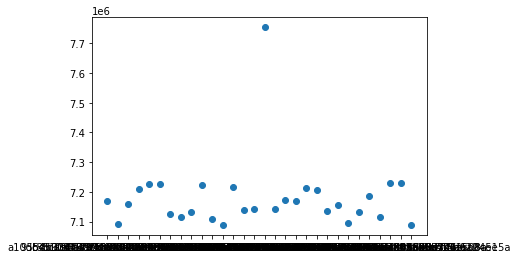

In [133]:
# manager_id
fig, ax =  plt.subplots()
ax.scatter(df_date["manager_id"][:30], df_date["listing_id"][:30])

### One-hot

In [281]:
# Use pandas unstead sklearn onehot
df_onehot = df_date.copy()
df_onehot.drop('display_address', axis=1, inplace=True)
df_onehot.drop('street_address', axis=1, inplace=True)
df_onehot.drop('description', axis=1, inplace=True)
df_onehot.drop('features', axis=1, inplace=True)
# df_onehot.drop('building_id', axis=1, inplace=True)
# df_onehot.drop('manager_id', axis=1, inplace=True)
# df_onehot = pd.get_dummies(df_onehot, columns=['building_id'])


In [283]:
# df_onehot = pd.get_dummies(df_onehot, columns=['manager_id'])
df_onehot.head(5)

,bathrooms,bedrooms,building_id,latitude,listing_id,longitude,manager_id,interest_level,log_price,addition_bath,geo_effect,Year,Month,Day,Hour,Min,Sec
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,medium,11.228819,0,0.996277,2016,6,16,5,55,27
6,1.0,2,b8e75fc949a6cd8225b455648a951712,40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,low,11.891784,0,0.987594,2016,6,1,5,44,33
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,medium,11.771077,0,1.007684,2016,6,14,15,19,59
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,medium,11.550747,1,1.015401,2016,6,24,7,54,24
15,1.0,1,bfb9405149bfff42a92980b594c28234,40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,low,11.448633,0,0.983101,2016,6,28,3,50,23


In [284]:
# df_onehot.drop('building_id', axis=1, inplace=True)
# df_onehot.drop('manager_id', axis=1, inplace=True)
# df_onehot.head(1)

### freq managers

In [285]:
df_count_m = df_onehot.copy()
df_count_m = df_count_m.groupby(['manager_id']).size().reset_index(name='count_man')
df_count_m.head()

,manager_id,count_man
0,0000abd7518b94c35a90d64b56fbf3e6,12
1,001ce808ce1720e24a9510e014c69707,10
2,003fc4e9a70053082f131b1054966aaf,1
3,00607a02f6efd9c6c7c588826e471ee9,2
4,00995ff28d79127ed2dca8320e9e7d09,3


In [286]:
df_onehot.loc[(df_onehot['manager_id'] == '0000abd7518b94c35a90d64b56fbf3e6')].shape

(12, 17)

In [287]:
df_merge = df_onehot.copy()
df_merge = df_merge.merge(df_count_m, on='manager_id', how='left')
df_merge.drop('manager_id', axis=1, inplace=True)
df_merge.head(5)

,bathrooms,bedrooms,building_id,latitude,listing_id,longitude,interest_level,log_price,addition_bath,geo_effect,Year,Month,Day,Hour,Min,Sec,count_man
0,1.0,1,8579a0b0d54db803821a35a4a615e97a,40.7108,7170325,-73.9539,medium,11.228819,0,0.996277,2016,6,16,5,55,27,112
1,1.0,2,b8e75fc949a6cd8225b455648a951712,40.7513,7092344,-73.9722,low,11.891784,0,0.987594,2016,6,1,5,44,33,26
2,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,40.7575,7158677,-73.9625,medium,11.771077,0,1.007684,2016,6,14,15,19,59,93
3,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,40.7145,7211212,-73.9425,medium,11.550747,1,1.015401,2016,6,24,7,54,24,90
4,1.0,1,bfb9405149bfff42a92980b594c28234,40.7439,7225292,-73.9743,low,11.448633,0,0.983101,2016,6,28,3,50,23,55


In [288]:
df_count_build = df_onehot.copy()
df_count_build = df_count_build.groupby(['building_id']).size().reset_index(name='count_build')
df_count_build.head()

,building_id,count_build
0,0,8286
1,00005cb939f9986300d987652c933e15,1
2,00024d77a43f0606f926e2312513845c,3
3,000ae4b7db298401cdae2b0ba1ea8146,1
4,0012f1955391bca600ec301035b97b65,1


In [289]:
df_onehot.loc[(df_onehot['building_id'] == '00024d77a43f0606f926e2312513845c')].shape

(3, 17)

In [290]:
df_merge = df_merge.merge(df_count_build, on='building_id', how='left')
df_merge.drop('building_id', axis=1, inplace=True)
df_merge.head(5)

,bathrooms,bedrooms,latitude,listing_id,longitude,interest_level,log_price,addition_bath,geo_effect,Year,Month,Day,Hour,Min,Sec,count_man,count_build
0,1.0,1,40.7108,7170325,-73.9539,medium,11.228819,0,0.996277,2016,6,16,5,55,27,112,5
1,1.0,2,40.7513,7092344,-73.9722,low,11.891784,0,0.987594,2016,6,1,5,44,33,26,51
2,1.0,2,40.7575,7158677,-73.9625,medium,11.771077,0,1.007684,2016,6,14,15,19,59,93,71
3,1.5,3,40.7145,7211212,-73.9425,medium,11.550747,1,1.015401,2016,6,24,7,54,24,90,3
4,1.0,1,40.7439,7225292,-73.9743,low,11.448633,0,0.983101,2016,6,28,3,50,23,55,86


## description, features

In [268]:
# bf_des = df_onehot.copy()
# df_des.head(5)


In [269]:
# df_des.drop('description', axis=1, inplace=True)
# df_des.drop('features', axis=1, inplace=True)
# df_des.head(3)


# 2. Modeling

## Split the data

In [139]:
# # Function for splitting data
# def splitting(df): 
#   x = df.drop("interest_level", axis=1)
#   y = df['interest_level']
#   from sklearn.model_selection import train_test_split
#   x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
#   return x_train, x_test, y_train, y_test

In [140]:
# x_train, x_test, y_train, y_test = splitting(df_des)

In [291]:
# Function for splitting data
def splitting_full(df): 
  x = df.drop("interest_level", axis=1)
  y = df['interest_level']
  return x, y

In [292]:
x, y = splitting_full(df_merge)

In [293]:
x.shape, y.shape

((49352, 16), (49352,))

In [294]:
x.head(1)

,bathrooms,bedrooms,latitude,listing_id,longitude,log_price,addition_bath,geo_effect,Year,Month,Day,Hour,Min,Sec,count_man,count_build
0,1.0,1,40.7108,7170325,-73.9539,11.228819,0,0.996277,2016,6,16,5,55,27,112,5


## Modeling

In [145]:
!pip install catboost


In [146]:
# # Put model in a dictionary

# from sklearn.linear_model import LogisticRegression # see the map
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import GaussianNB
# from catboost import CatBoostClassifier


# models = {"KNN": KNeighborsClassifier(),
#          "Random Forest": RandomForestClassifier(),
#           "Naive Bayes": GaussianNB(),
#           "CatBoost": CatBoostClassifier(verbose=False)}

# # Create the function to fit and score models
# def fit_and_score(models, x_train, x_test, y_train, y_test):
#     """
#     Fits and evaluates given ml models
#     """
    
#     # Set random seed
#     np.random.seed(42)
#     # Make a dictionary to keep scores
#     model_scores = {}
#     #Loop through model
#     for name, model in models.items():
#         # Fit the model to the data
#         model.fit(x_train, y_train)
#         # Evaluate the model append its scores to model_scores
#         model_scores[name] = model.score(x_test, y_test)
#     return model_scores

In [147]:
# model_scores = fit_and_score(models=models,
#                             x_train=x_train,
#                             x_test=x_test,
#                             y_train=y_train,
#                             y_test=y_test)
# model_scores

In [295]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
model_RF = RandomForestClassifier(verbose=False)
model_RF.fit(x, y)

RandomForestClassifier(verbose=False)

In [296]:
model_RF.score(x, y)

1.0

In [297]:
# predictions = model_RF.predict_proba(x_test)

In [298]:
# predictions[:8]

In [299]:
# y_pred = model_RF.predict(x_test)
# y_pred[:8]

In [300]:
# result = pd.DataFrame(predictions, columns=['high', 'low', 'medium'])
# result.head()

## Tuning

In [ ]:
# np.random.seed(42)
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# # Setup hyperparams..
# # Create a hyperparameter grid for RandomForestClassifier

# rf_grid = {"n_estimators": np.arange(10, 1000, 50),
#           "max_depth": [None, 3, 5, 10],
#            "min_samples_split": np.arange(2, 20, 2),
#            "min_samples_leaf": np.arange(1, 20, 2)
#           }
# rs_rf = RandomizedSearchCV(RandomForestClassifier(),
#                           param_distributions=rf_grid,
#                           cv=5,
#                           n_iter=20,
#                           verbose =True,
#                            n_jobs=-1)

# # Fit 
# rs_rf.fit(x_train, y_train)

In [ ]:
# rs_rf.best_params_

In [ ]:
# rs_rf.score(x_test, y_test)

In [ ]:
# rs_rf.predict_proba(x_test)

# 3. Test data

In [301]:
df_test = pd.read_json('/content/drive/MyDrive/Colab_Notebooks/CFT_work/test.json')

In [302]:
df_test.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street
2,1.0,0,0,2016-06-17 01:23:39,Spacious studio in Prime Location. Cleanbuildi...,Sullivan Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7260,7174566,-74.0026,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/7174566_ba3a35c5...,2295,115 Sullivan Street


In [303]:
df_test.shape

(74659, 14)

In [304]:
df_test.isna().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
dtype: int64

## Preprocess test data

In [305]:
df_test.drop('photos', axis = 1, inplace=True)

df_price = df_test.copy()
# log price
df_price['log_price'] = np.log2(df_price['price'])
df_price.drop('price',axis=1, inplace=True)
df_price.head(1)

# change '0' to '1'
df_baths = df_price.copy()

def bath(x):
  if x == 0:
    return 1
  else:
    return x

df_baths['bathrooms'] = df_price.apply(lambda x: bath(x['bathrooms']), axis=1)

# remove max 10. See distribution why
def bath_max(x):
  if x > 5:
    return df_baths['bathrooms'].mean()
  else:
    return x

df_baths['bathrooms'] = df_baths.apply(lambda x: bath_max(x['bathrooms']), axis=1)

# make a new feature

def add_tiol(x):
  if (x).is_integer() == True:
    return 0
  else:
    # if not a whole (plus toilet for example)
    return 1

df_baths['addition_bath'] = df_baths.apply(lambda x: add_tiol(x['bathrooms']), axis=1)

df_beds = df_baths.copy()

def bedroom(x):
  if x == 0:
    return 1
  else:
    return x

df_beds['bedrooms'] = df_beds.apply(lambda x: bedroom(x['bedrooms']), axis=1)

x = df_beds.copy()
x = x.drop('bathrooms', axis=1)
x = x.drop('bedrooms', axis=1)
x = x.drop('building_id', axis=1)
x = x.drop('created', axis=1)
x = x.drop('description', axis=1)
x = x.drop('display_address', axis=1)
x = x.drop('features', axis=1)
x = x.drop('listing_id', axis=1)
x = x.drop('manager_id', axis=1)
x = x.drop('street_address', axis=1)
# x = x.drop('interest_level', axis=1)
x = x.drop('addition_bath', axis=1)
y = x['log_price']
x = x.drop('log_price', axis=1)

# x['longitude'] = x['longitude'].abs()

from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor()
clf = clf.fit(x, y)

y_preds = clf.predict(x)
df_discrict_price = df_beds.copy()
df_discrict_price['distr_eff'] = y_preds


# price dependence on geography
def geo_price(x, y):
  return x/y

df_discrict_price['geo_effect'] = df_discrict_price.apply(lambda x: geo_price(x['log_price'], x['distr_eff']), axis=1)
df_discrict_price.drop('distr_eff', axis=1, inplace=True)

df_discrict_price['created'] = pd.to_datetime(df_discrict_price['created'], format='%Y-%m-%d %H:%M:%S')
# Add datetime parameter
df_date = df_discrict_price.copy()
df_date["Year"] = df_date.created.dt.year
df_date["Month"] = df_date.created.dt.month
df_date["Day"] = df_date.created.dt.day

df_date["Hour"] = df_date.created.dt.hour
df_date["Min"] = df_date.created.dt.minute
df_date["Sec"] = df_date.created.dt.second


# Now we can remove date column
df_date.drop("created", axis =1, inplace=True)

df_onehot = df_date.copy()
df_onehot.drop('display_address', axis=1, inplace=True)
df_onehot.drop('street_address', axis=1, inplace=True)
df_onehot.drop('description', axis=1, inplace=True)
df_onehot.drop('features', axis=1, inplace=True)
# df_onehot.drop('building_id', axis=1, inplace=True)
# df_onehot.drop('manager_id', axis=1, inplace=True)
# df_onehot = pd.get_dummies(df_onehot, columns=['building_id'])
# df_onehot = pd.get_dummies(df_onehot, columns=['manager_id'])

df_count_m = df_onehot.copy()
df_count_m = df_count_m.groupby(['manager_id']).size().reset_index(name='count_man')
df_merge = df_onehot.copy()
df_merge = df_merge.merge(df_count_m, on='manager_id', how='left')
df_merge.drop('manager_id', axis=1, inplace=True)

df_count_build = df_onehot.copy()
df_count_build = df_count_build.groupby(['building_id']).size().reset_index(name='count_build')
df_merge = df_merge.merge(df_count_build, on='building_id', how='left')
df_merge.drop('building_id', axis=1, inplace=True)
df_merge.head(5)

df_test = df_merge.copy()


## Prediction

In [306]:
df_test.head(10)

,bathrooms,bedrooms,latitude,listing_id,longitude,log_price,addition_bath,geo_effect,Year,Month,Day,Hour,Min,Sec,count_man,count_build
0,1.0,1,40.7185,7142618,-73.9865,11.526499,0,1.000201,2016,6,11,5,29,41,38,5
1,1.0,2,40.7278,7210040,-74.0000,11.476746,0,1.002511,2016,6,24,6,36,34,17,12378
2,1.0,1,40.7260,7174566,-74.0026,11.164278,0,1.000000,2016,6,17,1,23,39,3854,12378
3,1.0,2,40.7321,7191391,-74.0028,11.501837,0,1.001826,2016,6,21,5,6,2,176,10
4,1.0,1,40.7054,7171695,-74.0095,11.667999,0,1.002077,2016,6,16,7,24,27,35,94
5,2.0,2,40.7610,7225206,-73.9983,12.284824,0,1.009642,2016,6,28,3,44,52,87,151
6,3.5,4,40.7358,7200075,-73.9877,14.287712,1,1.023837,2016,6,22,5,14,51,127,2
7,1.0,1,40.7814,7145074,-73.9507,11.070121,0,0.959130,2016,6,12,2,24,10,111,17
8,2.0,4,40.7216,7193645,-73.9927,12.666224,0,1.054581,2016,6,21,6,50,23,56,29
9,1.0,1,40.7553,7147703,-73.9953,11.716391,0,1.000056,2016,6,12,7,35,4,7,46


In [313]:
df_test.shape

(74659, 16)

In [314]:
predictions = model_RF.predict_proba(df_test)

In [315]:
predictions[:8]

array([[0.04, 0.67, 0.29],
       [0.06, 0.8 , 0.14],
       [0.  , 0.98, 0.02],
       [0.31, 0.36, 0.33],
       [0.01, 0.9 , 0.09],
       [0.  , 0.65, 0.35],
       [0.  , 0.95, 0.05],
       [0.07, 0.58, 0.35]])

In [316]:
y_pred = model_RF.predict(df_test)
y_pred[:8]

array(['low', 'low', 'low', 'low', 'low', 'low', 'low', 'low'],
      dtype=object)

In [317]:
result = pd.DataFrame(predictions, columns=['high', 'low', 'medium'])
result.head()

,high,low,medium
0,0.04,0.67,0.29
1,0.06,0.80,0.14
2,0.00,0.98,0.02
3,0.31,0.36,0.33
4,0.01,0.90,0.09


In [312]:
# df_final = df_test['listing_id']
# df_final = pd.concat([df_final, result], axis=1)
# df_final.head()

In [318]:
result = result[['high', 'medium', 'low']]
result.head()

,high,medium,low
0,0.04,0.29,0.67
1,0.06,0.14,0.80
2,0.00,0.02,0.98
3,0.31,0.33,0.36
4,0.01,0.09,0.90


# 4. Sample submission

In [319]:
sample_sub = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/CFT_work/sample_submission.csv')

In [320]:
sample_sub.head()

,listing_id,high,medium,low
0,7142618,0.077788,0.227529,0.694683
1,7210040,0.077788,0.227529,0.694683
2,7174566,0.077788,0.227529,0.694683
3,7191391,0.077788,0.227529,0.694683
4,7171695,0.077788,0.227529,0.694683


In [321]:
sample_sub.dtypes

listing_id      int64
high          float64
medium        float64
low           float64
dtype: object

In [322]:
sample_sub.shape

(74659, 4)

In [323]:
sample_sub.drop('high', axis=1, inplace=True)
sample_sub.drop('medium', axis=1, inplace=True)
sample_sub.drop('low', axis=1, inplace=True)
sample_sub.head()

,listing_id
0,7142618
1,7210040
2,7174566
3,7191391
4,7171695


In [324]:
sample_sub = pd.concat([sample_sub, result], axis=1)
sample_sub.head()

,listing_id,high,medium,low
0,7142618,0.04,0.29,0.67
1,7210040,0.06,0.14,0.80
2,7174566,0.00,0.02,0.98
3,7191391,0.31,0.33,0.36
4,7171695,0.01,0.09,0.90


In [325]:
sample_sub.to_csv("/content/drive/MyDrive/Colab_Notebooks/outputs/sample_submission.csv", index=False)